In [1]:
import sys
print(sys.path) 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/gcta/scripts')

['/data/cellardata2/users/mpagadal/projects/germline-immune/disease-relevance/notebooks', '/nrnb/opt/anaconda3.7/lib/python37.zip', '/nrnb/opt/anaconda3.7/lib/python3.7', '/nrnb/opt/anaconda3.7/lib/python3.7/lib-dynload', '', '/cellar/users/mpagadal/.local/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/extensions', '/cellar/users/mpagadal/.ipython']


In [2]:
import pandas as pd
import os
import numpy as np
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [3]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get UKBB results

In [6]:
directory="/cellar/users/hik010/Data/plato/meghana_tcga/no-recode/"
plato=pd.read_csv(directory+"plato_all_results.txt",delimiter="\t")

In [12]:
icd=pd.read_csv("/cellar/users/hik010/Data/plato/icd_groups.txt",delimiter="\t")
print(icd.shape)
icd.head()

(263, 9)


,code,description,node_id,parent_id,selectable,letter,start,end,list
0,A00-A09,A00-A09 Intestinal infectious diseases,23,1,N,A,A00,A09,"A00,A01,A02,A03,A04,A05,A06,A07,A08,A09"
1,A15-A19,A15-A19 Tuberculosis,24,1,N,A,A15,A19,"A15,A16,A17,A18,A19"
2,A20-A28,A20-A28 Certain zoonotic bacterial diseases,25,1,N,A,A20,A28,"A20,A21,A22,A23,A24,A25,A26,A27,A28"
3,A30-A49,A30-A49 Other bacterial diseases,26,1,N,A,A30,A49,"A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,A4..."
4,A50-A64,A50-A64 Infections with a predominantly sexual...,27,1,N,A,A50,A64,"A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,A6..."


In [14]:
mp_dict=dict(zip(icd["code"],icd["description"]))

In [15]:
plato["description"]=plato["Outcome"].map(mp_dict)

In [16]:
plato.head()

,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_Missing,Analysis_Type,Converged,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval,Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR,description
0,C43-C44,rs76265950,16:90085139,A:0.897418,105850,logistic,1,1.141520e-38,0.784687,0.018644,6.009500e-37,8.466180e-33,7.055910e-33,C43-C44 Melanoma and other malignant neoplasms...
1,C43-C44,rs77603042,16:90083239,A:0.897478,105980,logistic,1,1.963290e-38,0.785179,0.018655,1.001690e-36,1.411180e-32,7.055910e-33,C43-C44 Melanoma and other malignant neoplasms...
2,C43-C44,rs6928272,6:32596635,A:0.843979,104996,logistic,1,1.159040e-12,0.892518,0.015992,2.056100e-12,2.896640e-08,9.655470e-09,C43-C44 Melanoma and other malignant neoplasms...
3,C43-C44,rs6457621,6:32664117,A:0.828846,175939,logistic,1,1.068300e-11,0.889592,0.017212,1.762100e-11,2.482450e-07,6.206110e-08,C43-C44 Melanoma and other malignant neoplasms...
4,D60-D64,rs17612852,6:32620572,G:0.248427,107855,logistic,1,4.079810e-11,0.909325,0.014399,2.878530e-11,4.055280e-07,8.110550e-08,D60-D64 Aplastic and other anaemias


In [17]:
len(plato["Var1_ID"].unique())

577

In [18]:
def ppoints(n, a):
    """ numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number"""
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

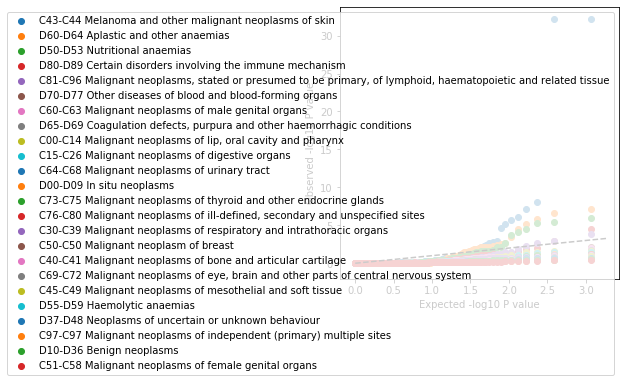

In [19]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for x in plato["description"].unique():
    plato_disease=plato[plato["description"]==x]
    p_values=plato_disease.sort_values(by="Overall_Pval_adj_FDR")["Overall_Pval_adj_FDR"].tolist()
    plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values),label=x)
ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
plt.legend()
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel('Observed -log10 P value')
plt.savefig("../plots/ukbb.pdf")

## Mendelian Randomization 

In [27]:
ukbb_snps=plato[plato["Overall_Pval_adj_FDR"]<.05]
print(ukbb_snps.shape)
ukbb_snps.head()

(84, 14)


,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_Missing,Analysis_Type,Converged,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval,Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR,description
0,C43-C44,rs76265950,16:90085139,A:0.897418,105850,logistic,1,1.141520e-38,0.784687,0.018644,6.009500e-37,8.466180e-33,7.055910e-33,C43-C44 Melanoma and other malignant neoplasms...
1,C43-C44,rs77603042,16:90083239,A:0.897478,105980,logistic,1,1.963290e-38,0.785179,0.018655,1.001690e-36,1.411180e-32,7.055910e-33,C43-C44 Melanoma and other malignant neoplasms...
2,C43-C44,rs6928272,6:32596635,A:0.843979,104996,logistic,1,1.159040e-12,0.892518,0.015992,2.056100e-12,2.896640e-08,9.655470e-09,C43-C44 Melanoma and other malignant neoplasms...
3,C43-C44,rs6457621,6:32664117,A:0.828846,175939,logistic,1,1.068300e-11,0.889592,0.017212,1.762100e-11,2.482450e-07,6.206110e-08,C43-C44 Melanoma and other malignant neoplasms...
4,D60-D64,rs17612852,6:32620572,G:0.248427,107855,logistic,1,4.079810e-11,0.909325,0.014399,2.878530e-11,4.055280e-07,8.110550e-08,D60-D64 Aplastic and other anaemias


In [28]:
ukbb_snps["description"].value_counts()

D60-D64 Aplastic and other anaemias                                                                              24
C43-C44 Melanoma and other malignant neoplasms of skin                                                           19
D50-D53 Nutritional anaemias                                                                                     17
C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue     7
D80-D89 Certain disorders involving the immune mechanism                                                          6
C00-C14 Malignant neoplasms of lip, oral cavity and pharynx                                                       4
C15-C26 Malignant neoplasms of digestive organs                                                                   3
C60-C63 Malignant neoplasms of male genital organs                                                                2
D70-D77 Other diseases of blood and blood-forming organs                

In [30]:
nonhla_snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")
hla_snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-hla.tsv",delimiter="\t")


In [35]:
rsid_mapping=nonhla_snps[["rsid","file"]].append(hla_snps[["rsid","file"]])

In [37]:
pheno_mapping=rsid_mapping[rsid_mapping["rsid"].isin(ukbb_snps["Var1_ID"].tolist())]

In [38]:

G=nx.Graph()

for i,row in ukbb_snps.iterrows():
    G.add_edge(row["Var1_ID"],row["description"])
for i,row in pheno_mapping.iterrows():
    G.add_edge(row["rsid"],row["file"])

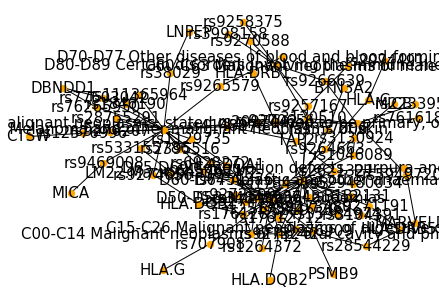

In [39]:
nx.draw(G, with_labels=True, node_color='orange', node_size=40, font_size=15)

In [40]:
final = ndex2.create_nice_cx_from_networkx(G)
final.upload_to('http://public.ndexbio.org', username = 'meghanasp21', password = 'student16')

Generating CX


'http://public.ndexbio.org/v2/network/bb849304-360b-11eb-9e72-0ac135e8bacf'

In [46]:
node=[]
degree=[]
color=[]

for x in G.nodes():
    node.append(x)
    degree.append(len([x for x in G.neighbors(x)]))
    if "rs" in x:
        color.append("red")
    elif "-" in x :
        color.append("purple")
    else:
        color.append("blue")
        

In [47]:
df=pd.DataFrame({"node":node,"degree":degree,"color":color})

In [49]:
df.to_csv("ukbb.network.nodes.csv",index=None)

In [65]:
snps[~(snps["ukbb"].isnull())]["ukbb"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[ Melanoma and other malignant neoplasms of skin ]                                                                                                    5
[ Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue ]                                             1
[ Malignant neoplasms of digestive organs ]                                                                                                           1
[ Aplastic and other anaemias,  Nutritional anaemias,  Malignant neoplasms of digestive organs ,  Melanoma and other malignant neoplasms of skin ]    1
Name: ukbb, dtype: int64

In [72]:
snps[~snps["ukbb"].isnull()]

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,...,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,gwas,ukbb
15,5:68650237:C:T,MARVELD2,immunomodulators,0.05793,chr5:g.68650237T>C,rs28544229,0.415271,0.034952,2.997640e-32,C,...,-0.082284,0.036171,2.294670e-02,-0.085544,0.035597,1.628190e-02,2.997640e-32,60701.0,NaN,[ Malignant neoplasms of digestive organs ]
22,5:68457065:C:T,MARVELD2,immunomodulators,0.14000,chr5:g.68457065C>T,rs59497209,-0.233469,0.023968,2.783960e-22,C,...,0.039840,0.024643,1.059940e-01,0.036200,0.024184,1.344710e-01,2.783960e-22,253873.0,NaN,"[ Malignant neoplasms, stated or presumed to b..."
162,16:90083239:A:G,DBNDD1,immunomodulators,0.07624,chr16:g.90083239A>G,rs77603042,0.290354,0.031336,2.519270e-20,A,...,0.299686,0.031737,4.861770e-21,0.310467,0.031154,3.051980e-23,3.051980e-23,-11961.0,"['Squamous cell carcinoma', 'Facial pigmentati...",[ Melanoma and other malignant neoplasms of sk...
169,6:32605437:G:C,LM22.Macrophages.M2,immune infiltration,0.41890,chr6:g.32605437C>G,rs7751376,0.165400,0.016619,3.488580e-23,G,...,0.014453,0.017036,3.962530e-01,0.019322,0.016731,2.481940e-01,3.488580e-23,NaN,"['Asthma (childhood onset)', 'Chronic lymphocy...","[ Aplastic and other anaemias, Nutritional an..."
170,6:32624038:C:T,LM22.Macrophages.M2,immune infiltration,0.13110,chr6:g.32624038C>T,rs533155786,-0.162562,0.024598,4.155350e-11,C,...,-0.065425,0.025223,9.509200e-03,-0.060489,0.024745,1.452990e-02,4.155350e-11,NaN,NaN,[ Melanoma and other malignant neoplasms of sk...
211,11:65580638:T:G,CTSW,cell type,0.26790,chr11:g.65580638T>G,rs12576996,0.131006,0.018942,5.037580e-12,T,...,0.164165,0.019188,1.428130e-17,0.163810,0.018838,4.229780e-18,4.229780e-18,66645.0,['Parental longevity (combined parental attain...,[ Melanoma and other malignant neoplasms of sk...
342,16:90085139:A:C,DBNDD1,immunomodulators,0.07600,chr16:g.90085139A>C,rs76265950,0.290589,0.031364,2.537760e-20,A,...,0.301608,0.031776,3.067170e-21,0.312277,0.031191,1.930800e-23,1.930800e-23,-13861.0,"['Squamous cell carcinoma', 'Facial pigmentati...",[ Melanoma and other malignant neoplasms of sk...
431,5:96353223:G:C,LNPEP,antigen present,0.40060,chr5:g.96353223C>G,rs38029,0.083899,0.016989,8.051590e-07,G,...,0.095274,0.017207,3.188920e-08,0.099687,0.016840,3.375470e-09,3.375470e-09,-81878.0,"['Pediatric autoimmune diseases', 'White blood...",[ Melanoma and other malignant neoplasms of sk...


In [71]:
snps

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,...,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,gwas,ukbb
0,19:7789796:T:C,CD209,cell type,0.25930,chr19:g.7789796T>C,rs10422720,-0.153826,0.018988,6.358100e-16,T,...,-0.174974,0.019221,1.126740e-19,-0.178179,0.018876,4.971470e-21,4.971470e-21,15084.0,['Blood protein levels'],NaN
1,19:7768298:A:G,CD209,cell type,0.15010,chr19:g.7768298A>G,rs58901714,-0.143563,0.023409,9.105090e-10,A,...,-0.157023,0.023889,5.293960e-11,-0.151253,0.023379,1.047650e-10,5.293960e-11,36582.0,NaN,NaN
2,3:159633885:T:C,CD209,cell type,0.01491,chr3:g.159633885T>C,rs76992466,-0.374997,0.068493,4.525630e-08,T,...,-0.340604,0.070042,1.182550e-06,-0.353152,0.068943,3.096210e-07,4.525630e-08,NaN,NaN,NaN
3,1:161508763:T:C,FCGR3B,cell type,0.36810,chr1:g.161508763T>C,rs10919544,0.166431,0.017210,5.489110e-22,T,...,0.237579,0.017299,2.300510e-42,0.236799,0.016959,9.737500e-44,9.737500e-44,84224.0,"['Takayasu arteritis', 'Blood protein levels']",NaN
4,1:161572353:T:C,FCGR3B,cell type,0.14500,chr1:g.161572353T>C,rs67775399,-0.136145,0.023202,4.615400e-09,T,...,-0.166241,0.023540,1.799250e-12,-0.163998,0.023030,1.174700e-12,1.174700e-12,20634.0,"['Blood protein levels', 'Offspring birth weig...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,5:96228072:C:T,ERAP1,antigen present,0.03280,chr5:g.96228072C>T,rs75263594,0.314825,0.046740,1.759080e-11,C,...,0.415443,0.047087,1.394430e-18,0.441081,0.045959,1.108240e-21,1.108240e-21,-117885.0,NaN,NaN
478,19:52151750:C:T,SIGLEC5,cell type,0.02647,chr19:g.52151750C>T,rs138816179,-0.426090,0.051681,1.955820e-16,C,...,-0.271523,0.053179,3.382250e-07,-0.282401,0.051787,5.115210e-08,1.955820e-16,-36995.0,NaN,NaN
479,3:47672891:T:C,TREX1,antigen present,0.34310,chr3:g.47672891T>C,rs1568691,0.108833,0.017492,5.189550e-10,T,...,0.101138,0.017753,1.268690e-08,0.108484,0.017414,4.936200e-10,4.936200e-10,834027.0,NaN,NaN
480,3:48343261:G:A,TREX1,antigen present,0.29480,chr3:g.48343261G>A,rs34630841,-0.124618,0.018304,1.068290e-11,G,...,-0.106043,0.018541,1.112900e-08,-0.106346,0.018229,5.646740e-09,1.068290e-11,163657.0,['Medication use (agents acting on the renin-a...,NaN
